## Algorithmic Bias
will holt, with the help of deepseek ai

intro
this section of our project is focused on identifying algorithmic bias present in historically 'racist' areas due to racial covenants. This section will adress how modern lending systems may perpetuate discrimination via mortgage approval rates and terms, risk assessment criteria, and use of potentially biased proxy variables.

import data

In [1]:
import pandas as pd
file_path = r'Data/mortgage_covenant_data.csv'
hmda_data = pd.read_csv(file_path)
hmda_data.head()

,activity_year,census_tract,derived_race,action_taken,loan_amount,property_value,income,interest_rate,tract_minority_population_percent,tract_to_msa_income_percentage,denial_reason-1,covenant_count,was_approved,covenant_density
0,2023,2.703706e+10,Race Not Available,6,185000.0,195000.0,NaN,6.125,40.37,73.48,10,0.0,False,NaN
1,2023,2.714103e+10,Race Not Available,6,375000.0,385000.0,NaN,6.625,10.64,121.26,10,0.0,False,NaN
2,2023,2.702395e+10,Race Not Available,6,105000.0,105000.0,NaN,6.125,8.92,90.13,10,0.0,False,NaN
3,2023,2.717110e+10,Race Not Available,6,285000.0,285000.0,NaN,6.750,13.27,104.37,10,0.0,False,NaN
4,2023,2.715948e+10,Race Not Available,6,175000.0,175000.0,NaN,6.875,5.87,82.22,10,0.0,False,NaN


explore and clean data

In [2]:
columns_to_keep = ['loan_amount', 'action_taken', 'derived_race', 'income', 'tract_minority_population_percent']
hmda_data = hmda_data[columns_to_keep]
print(hmda_data.head())

   loan_amount  action_taken        derived_race  income  \
0     185000.0             6  Race Not Available     NaN   
1     375000.0             6  Race Not Available     NaN   
2     105000.0             6  Race Not Available     NaN   
3     285000.0             6  Race Not Available     NaN   
4     175000.0             6  Race Not Available     NaN   

   tract_minority_population_percent  
0                              40.37  
1                              10.64  
2                               8.92  
3                              13.27  
4                               5.87  


clean data

In [3]:
# Drop rows with missing values in key columns
hmda_data = hmda_data.dropna(subset=['loan_amount', 'action_taken', 'income', 'tract_minority_population_percent'])
print(hmda_data.isnull().sum())

loan_amount                          0
action_taken                         0
derived_race                         0
income                               0
tract_minority_population_percent    0
dtype: int64


make action taken binary

In [4]:
# Create a new column 'approved' where 1 = approved and 0 = denied
hmda_data['approved'] = hmda_data['action_taken'].apply(lambda x: 1 if x == 1 else 0)
print(hmda_data['approved'].value_counts())

approved
1    62563
0    25637
Name: count, dtype: int64


analyze loan approval rates by race

In [5]:
if 'derived_race' in hmda_data.columns:
    approval_rates_by_race = hmda_data.groupby('derived_race')['approved'].mean()
    print(approval_rates_by_race)

derived_race
2 or more minority races                     0.622222
American Indian or Alaska Native             0.597163
Asian                                        0.687393
Black or African American                    0.585913
Free Form Text Only                          0.800000
Joint                                        0.729461
Native Hawaiian or Other Pacific Islander    0.553571
Race Not Available                           0.611235
White                                        0.739222
Name: approved, dtype: float64


key findings:
- white applicants have highest approval rate of 74%, followed by asian individuals at 69%
- black, hawaiian and pacific islanders both have approval rates near 55%, lowest of all
- suggestion is that racial disparities exist in loan approval rates, even if race is excluded as a factor altogether

approval rates by tract minority population

In [6]:
# Bin the minority population percentage into categories (e.g., low, medium, high)
hmda_data['minority_population_category'] = pd.cut(
    hmda_data['tract_minority_population_percent'],
    bins=[0, 20, 50, 100],
    labels=['Low', 'Medium', 'High']
)

# Calculate approval rates by minority population category
approval_rates_by_minority_population = hmda_data.groupby('minority_population_category')['approved'].mean()
print(approval_rates_by_minority_population)

minority_population_category
Low       0.733455
Medium    0.705028
High      0.639242
Name: approved, dtype: float64


key findings:
- low minority population tracts have highest approval rates, almost 75%
- high minority population rate result in way lower rates (64%)
- this indicates that having more minorities in an area will resultin biased loan approval decisions

proxy variables

In [7]:
correlation_income_approval = hmda_data['income'].corr(hmda_data['approved'])
print(f"Correlation between income and approval: {correlation_income_approval}")

Correlation between income and approval: 0.0037769435356970857


findings:
- very weak 0.0038 correlation
- implies income is a poor predictor of loan approval here

In [8]:
correlation_loan_amount_approval = hmda_data['loan_amount'].corr(hmda_data['approved'])
print(f"Correlation between loan amount and approval: {correlation_loan_amount_approval}")

Correlation between loan amount and approval: 0.04881710646375199


findings:
- the correlation is still small, 0.0488
- implies that the larger the loan, the slightly more likely it will be approved.

visuals

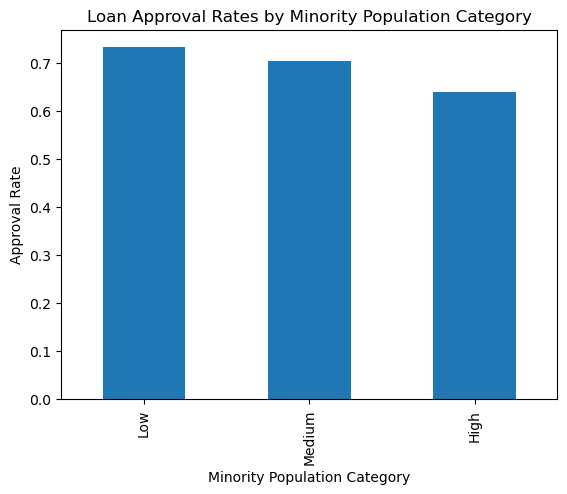

In [9]:
import matplotlib.pyplot as plt
approval_rates_by_minority_population.plot(kind='bar', title='Loan Approval Rates by Minority Population Category')
plt.xlabel('Minority Population Category')
plt.ylabel('Approval Rate')
plt.show()

findings:
- clearly shows trend that approval rates decline as minority population increases

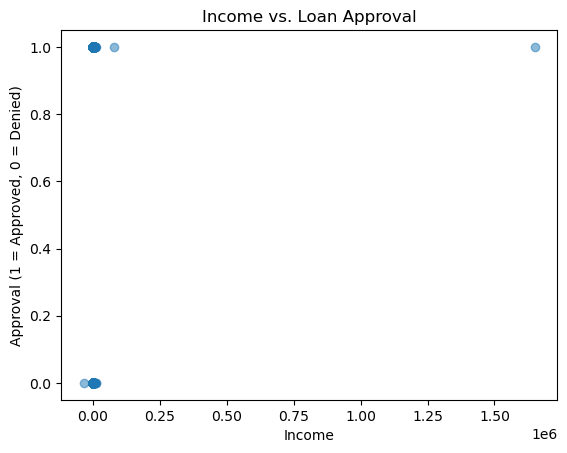

In [10]:
plt.scatter(hmda_data['income'], hmda_data['approved'], alpha=0.5)
plt.title('Income vs. Loan Approval')
plt.xlabel('Income')
plt.ylabel('Approval (1 = Approved, 0 = Denied)')
plt.show()

no clear relation found for income and loan approval, supporting the weak correlation found earlier.